In [1]:
import os
import cv2
import numpy as np
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

### Dataset Preparation

In [2]:
DATA_DIR = "/kaggle/input/iris-computer-vision"

In [3]:
# seed for reproducibility 
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# image configs
CLASS_NAMES = ["iris-setosa", "iris-versicolour", "iris-virginica"]
IMG_SIZE = (64, 64)

# noise configs
NOISE_RATIO_LOW = 0.05
NOISE_RATIO_HIGH = 0.15
ERASE_RATIO = 0.25 
GAUSS_MEAN = 0
GAUSS_STD = 25

# model configs
KNN_K = 5
TEST_SIZE = 0.20

In [4]:
# data loading

def load_images(data_dir, class_names, img_size):
    images, labels = [], []
    for cls in class_names:
        folder = Path(data_dir) / cls
        paths  = sorted(folder.glob("*.jpg"))
        for p in paths:
            img = cv2.imread(str(p))
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            images.append(img)
            labels.append(cls)
    return images, labels


all_images, all_labels = load_images(DATA_DIR, CLASS_NAMES, IMG_SIZE)

# encode labels to integers
le = LabelEncoder()
all_labels_enc = le.fit_transform(all_labels)

print(f"Total samples loaded : {len(all_images)}")
for cls in CLASS_NAMES:
    print(f"  {cls}: {all_labels.count(cls)}")

Total samples loaded : 421
  iris-setosa: 67
  iris-versicolour: 269
  iris-virginica: 85


In [5]:
# train-test split

X_all = np.array(all_images, dtype=np.float32)
y_all = all_labels_enc

X_train_base, X_test_base, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=y_all
)

print(f"Training samples: {len(X_train_base)}")
print(f"Test samples: {len(X_test_base)}")
print()

# cross-check class distribution
for i, cls in enumerate(le.classes_):
    tr = np.sum(y_train == i)
    te = np.sum(y_test == i)
    print(f"{cls} --> train: {tr}, test: {te}")

Training samples: 336
Test samples: 85

iris-setosa --> train: 53, test: 14
iris-versicolour --> train: 215, test: 54
iris-virginica --> train: 68, test: 17


In [6]:
# helper functions for adding noise and occlusion

def add_gaussian_noise(image, mean=GAUSS_MEAN, std=GAUSS_STD, var=0.01):
    return random_noise(image, mode="gaussian", var=var).astype(np.float32)


def add_occlusion(image, erase_ratio=ERASE_RATIO):
    img = image.copy()
    H, W = img.shape[:2]
    patch_area = int(H * W * erase_ratio)
    ph = int(np.sqrt(patch_area))
    pw = patch_area // ph
    top = random.randint(0, max(0, H - ph))
    left = random.randint(0, max(0, W - pw))
    img[top:top+ph, left:left+pw] = 0
    return img


def contaminate_dataset(X, y, noise_ratio, rng_seed=SEED):
    # noise_ratio fraction of samples get Gaussian noise
    # another noise_ratio fraction get occlusion
    # this way, one image will not get both
    
    rng = np.random.default_rng(rng_seed)
    X_out = X.copy()
    n = len(X_out)
    n_noisy = max(1, int(n * noise_ratio))

    all_idx = rng.permutation(n)
    gauss_idx = all_idx[:n_noisy]
    occlude_idx = all_idx[n_noisy: 2 * n_noisy]

    for i in gauss_idx:
        X_out[i] = add_gaussian_noise(X_out[i])
    for i in occlude_idx:
        X_out[i] = add_occlusion(X_out[i])

    print(f"Gaussian noise applied to: {len(gauss_idx)} samples")
    print(f"Occlusion applied to: {len(occlude_idx)} samples")
    print(f"Total contaminated: {len(gauss_idx)+len(occlude_idx)} out of {n} "
          f"({(len(gauss_idx)+len(occlude_idx))/n*100:.1f}%)")
    return X_out, y

In [7]:
# created augmented training sets

print("Creating training set with 10% contamination:")
X_train_noisy10, y_train_noisy10 = contaminate_dataset(
    X_train_base, y_train, noise_ratio=NOISE_RATIO_LOW, rng_seed=SEED
)

print("\nCreating training set with 30% contamination:")
X_train_noisy30, y_train_noisy30 = contaminate_dataset(
    X_train_base, y_train, noise_ratio=NOISE_RATIO_HIGH, rng_seed=SEED
)

Creating training set with 10% contamination:
Gaussian noise applied to: 16 samples
Occlusion applied to: 16 samples
Total contaminated: 32 out of 336 (9.5%)

Creating training set with 30% contamination:
Gaussian noise applied to: 50 samples
Occlusion applied to: 50 samples
Total contaminated: 100 out of 336 (29.8%)


In [8]:
# create augmented test set

print("Creating test set with 10% contamination")
X_test_noisy, y_test_noisy = contaminate_dataset(
    X_test_base, y_test, noise_ratio=NOISE_RATIO_LOW, rng_seed=SEED
)

Creating test set with 10% contamination
Gaussian noise applied to: 4 samples
Occlusion applied to: 4 samples
Total contaminated: 8 out of 85 (9.4%)


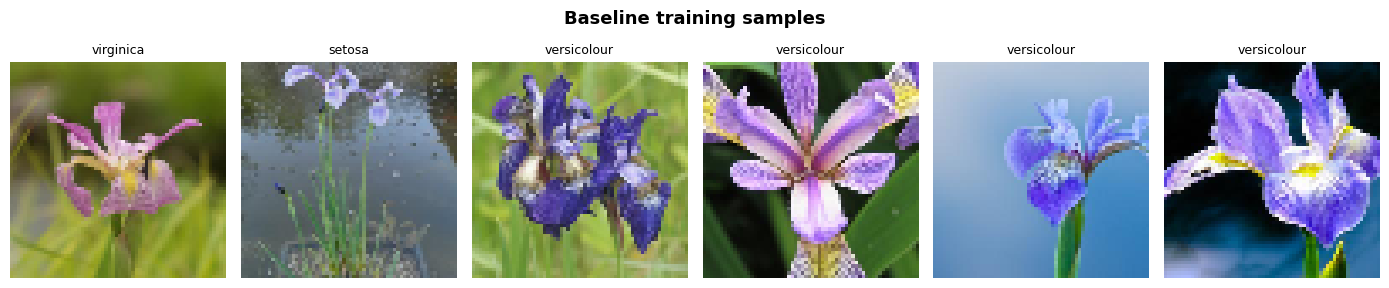

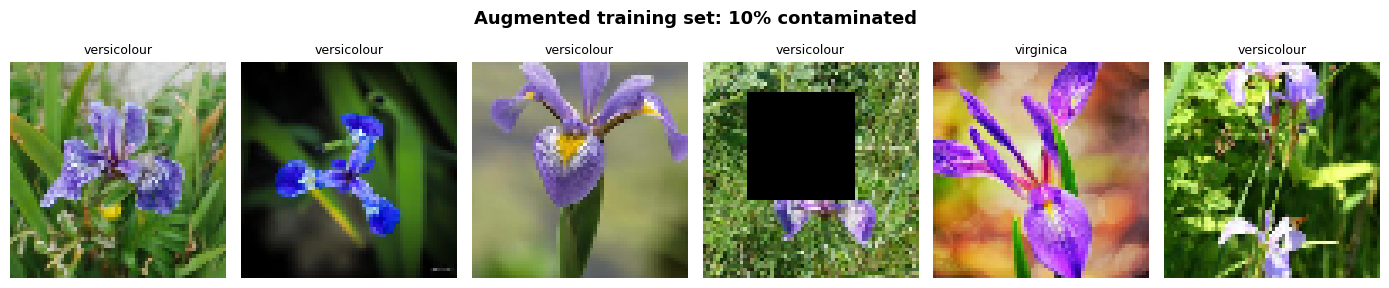

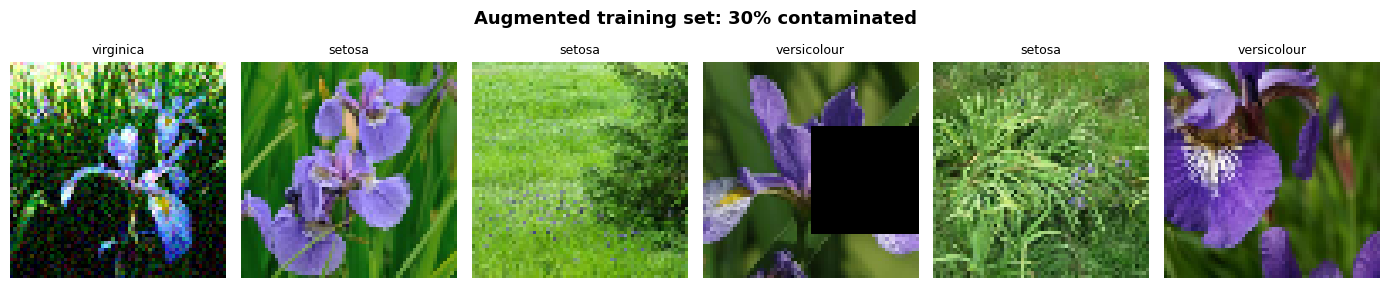

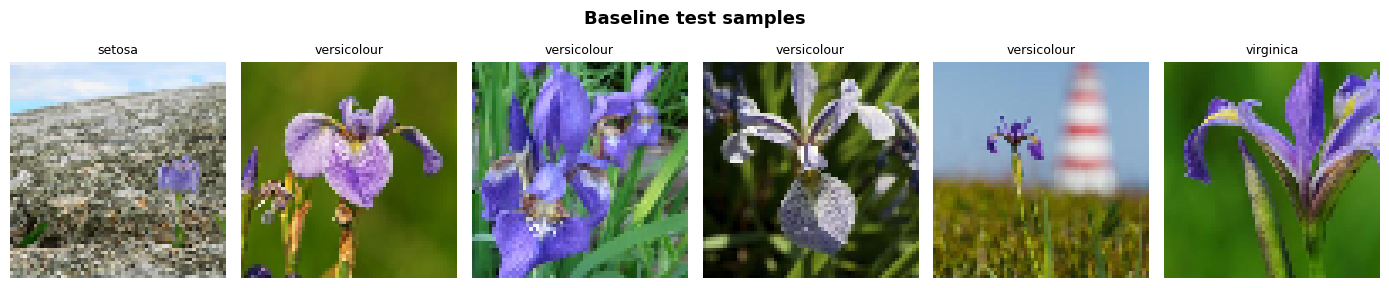

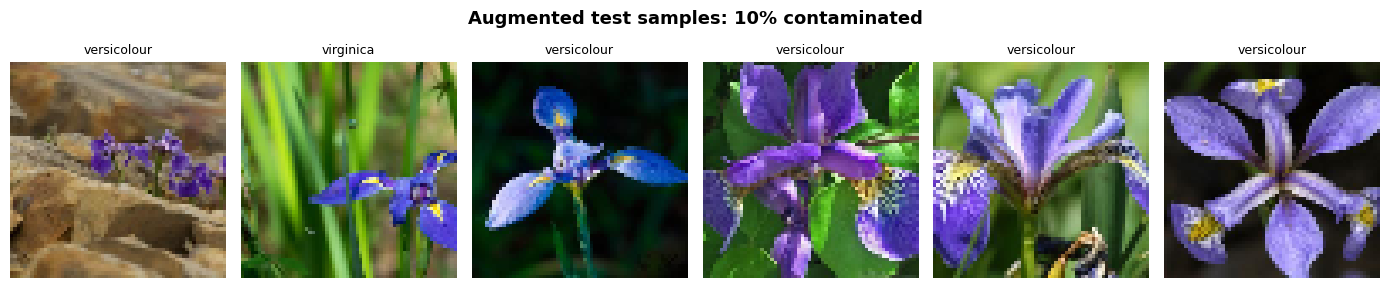

In [17]:
# cross-checking contamination
# since randomly choosing images, contamination may not always be visible

def show_sample_grid(images, labels, title, n=6):
    fig, axes = plt.subplots(1, n, figsize=(14, 3))
    fig.suptitle(title, fontsize=13, fontweight="bold")
    idx = random.sample(range(len(images)), n)
    for ax, i in zip(axes, idx):
        ax.imshow(images[i])
        ax.set_title(le.inverse_transform([labels[i]])[0].split("-")[-1], fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_grid(X_train_base, y_train, "Baseline training samples")
show_sample_grid(X_train_noisy10, y_train_noisy10, "Augmented training set: 10% contaminated")
show_sample_grid(X_train_noisy30, y_train_noisy30, "Augmented training set: 30% contaminated")
show_sample_grid(X_test_base, y_test, "Baseline test samples")
show_sample_grid(X_test_noisy, y_test_noisy, "Augmented test samples: 10% contaminated")

In [10]:
# feature extraction

def extract_features(images):
    # our classifiers cannot handle over 2D
    return images.reshape(len(images), -1)

F_train_base = extract_features(X_train_base)
F_train_noisy10 = extract_features(X_train_noisy10)
F_train_noisy30 = extract_features(X_train_noisy30)

F_test_base = extract_features(X_test_base)
F_test_noisy = extract_features(X_test_noisy)

print(f"Feature vector length : {F_train_base.shape[1]}")

Feature vector length : 12288


In [11]:
# feature scaling 

scaler = StandardScaler()

F_train_base_sc    = scaler.fit_transform(F_train_base)

F_train_noisy10_sc = scaler.transform(F_train_noisy10)
F_train_noisy30_sc = scaler.transform(F_train_noisy30)

F_test_base_sc     = scaler.transform(F_test_base)
F_test_noisy_sc    = scaler.transform(F_test_noisy)

### Model Training

In [12]:
# KNN 
knn_base = KNeighborsClassifier(n_neighbors=KNN_K, n_jobs=-1)
knn_noisy10 = KNeighborsClassifier(n_neighbors=KNN_K, n_jobs=-1)
knn_noisy30 = KNeighborsClassifier(n_neighbors=KNN_K, n_jobs=-1)

knn_base.fit(F_train_base_sc, y_train)
knn_noisy10.fit(F_train_noisy10_sc, y_train)
knn_noisy30.fit(F_train_noisy30_sc, y_train)

# logistic regression
lin_base = LogisticRegression(max_iter=1000, random_state=SEED)
lin_noisy10 = LogisticRegression(max_iter=1000, random_state=SEED)
lin_noisy30 = LogisticRegression(max_iter=1000, random_state=SEED)

lin_base.fit(F_train_base_sc, y_train)
lin_noisy10.fit(F_train_noisy10_sc, y_train)
lin_noisy30.fit(F_train_noisy30_sc, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Evaluation

In [13]:
def evaluate(model, X, y_true, model_name, test_name):
    y_pred = model.predict(X)
    
    # probability predictions for ROC
    y_prob = model.predict_proba(X)
    
    # one-vs-rest for multi-class ROC
    auc_roc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
        
    report = classification_report(y_true, y_pred, target_names=le.classes_, output_dict=True, zero_division=0)
    acc = report["accuracy"]
    
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)      
    f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0) 

    print(f"\n{'─'*65}")
    print(f"Model: {model_name} | Test: {test_name}")
    print(f"{'-'*65}")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Precision (Macro): {prec_macro*100:.2f}%")
    print(f"Recall (Macro): {rec_macro*100:.2f}%")
    print(f"F1 Macro: {f1_macro*100:.2f}%")
    print(f"F1 Weighted: {f1_weighted*100:.2f}%")
    print(f"AUC ROC (OVR): {auc_roc:.4f}")
    print(f"{'-'*65}")
    
    print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))
    
    return y_pred, acc, prec_macro, rec_macro, f1_macro, f1_weighted, auc_roc


def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, colorbar=False, cmap="Blues")
    ax.set_title(title, fontsize=11)
    plt.tight_layout()
    plt.show()


─────────────────────────────────────────────────────────────────
Model: KNN — baseline train | Test: Clean test
-----------------------------------------------------------------
Accuracy: 61.18%
Precision (Macro): 48.99%
Recall (Macro): 36.97%
F1 Macro: 35.11%
F1 Weighted: 52.93%
AUC ROC (OVR): 0.5527
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.33      0.14      0.20        14
iris-versicolour       0.64      0.91      0.75        54
  iris-virginica       0.50      0.06      0.11        17

        accuracy                           0.61        85
       macro avg       0.49      0.37      0.35        85
    weighted avg       0.56      0.61      0.53        85



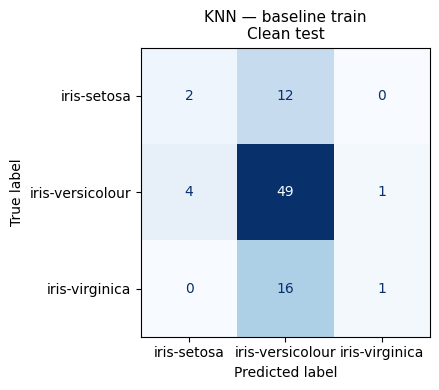


─────────────────────────────────────────────────────────────────
Model: KNN — baseline train | Test: Noisy test
-----------------------------------------------------------------
Accuracy: 61.18%
Precision (Macro): 48.99%
Recall (Macro): 36.97%
F1 Macro: 35.11%
F1 Weighted: 52.93%
AUC ROC (OVR): 0.5507
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.33      0.14      0.20        14
iris-versicolour       0.64      0.91      0.75        54
  iris-virginica       0.50      0.06      0.11        17

        accuracy                           0.61        85
       macro avg       0.49      0.37      0.35        85
    weighted avg       0.56      0.61      0.53        85



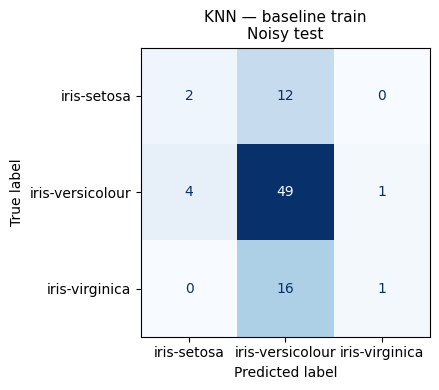


─────────────────────────────────────────────────────────────────
Model: KNN — 10% noisy train | Test: Clean test
-----------------------------------------------------------------
Accuracy: 61.18%
Precision (Macro): 48.99%
Recall (Macro): 36.97%
F1 Macro: 35.11%
F1 Weighted: 52.93%
AUC ROC (OVR): 0.5647
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.33      0.14      0.20        14
iris-versicolour       0.64      0.91      0.75        54
  iris-virginica       0.50      0.06      0.11        17

        accuracy                           0.61        85
       macro avg       0.49      0.37      0.35        85
    weighted avg       0.56      0.61      0.53        85



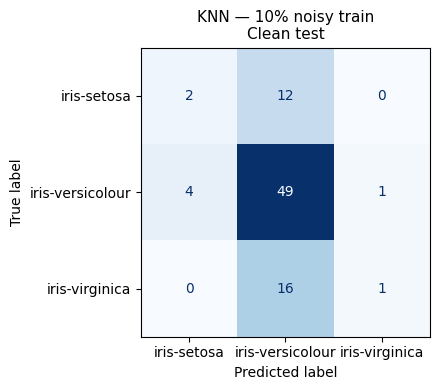


─────────────────────────────────────────────────────────────────
Model: KNN — 10% noisy train | Test: Noisy test
-----------------------------------------------------------------
Accuracy: 61.18%
Precision (Macro): 48.99%
Recall (Macro): 36.97%
F1 Macro: 35.11%
F1 Weighted: 52.93%
AUC ROC (OVR): 0.5622
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.33      0.14      0.20        14
iris-versicolour       0.64      0.91      0.75        54
  iris-virginica       0.50      0.06      0.11        17

        accuracy                           0.61        85
       macro avg       0.49      0.37      0.35        85
    weighted avg       0.56      0.61      0.53        85



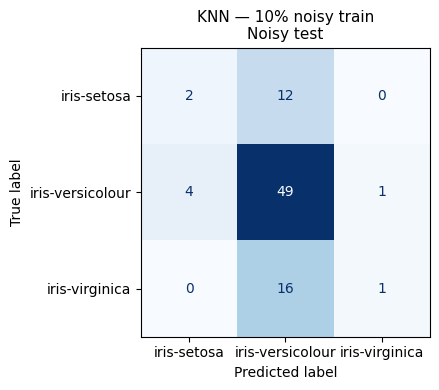


─────────────────────────────────────────────────────────────────
Model: KNN — 30% noisy train | Test: Clean test
-----------------------------------------------------------------
Accuracy: 61.18%
Precision (Macro): 29.32%
Recall (Macro): 33.86%
F1 Macro: 28.89%
F1 Weighted: 49.83%
AUC ROC (OVR): 0.5454
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.25      0.07      0.11        14
iris-versicolour       0.63      0.94      0.76        54
  iris-virginica       0.00      0.00      0.00        17

        accuracy                           0.61        85
       macro avg       0.29      0.34      0.29        85
    weighted avg       0.44      0.61      0.50        85



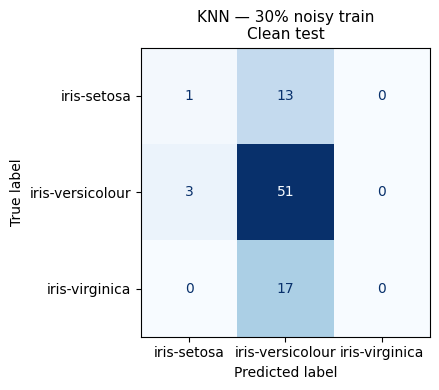


─────────────────────────────────────────────────────────────────
Model: KNN — 30% noisy train | Test: Noisy test
-----------------------------------------------------------------
Accuracy: 61.18%
Precision (Macro): 29.32%
Recall (Macro): 33.86%
F1 Macro: 28.89%
F1 Weighted: 49.83%
AUC ROC (OVR): 0.5332
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.25      0.07      0.11        14
iris-versicolour       0.63      0.94      0.76        54
  iris-virginica       0.00      0.00      0.00        17

        accuracy                           0.61        85
       macro avg       0.29      0.34      0.29        85
    weighted avg       0.44      0.61      0.50        85



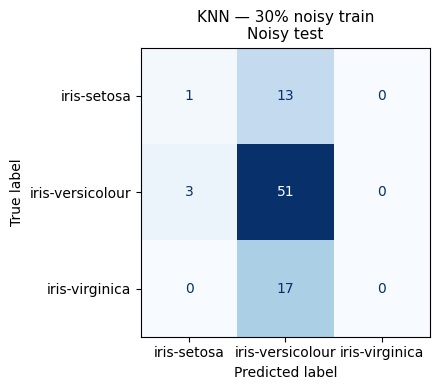


─────────────────────────────────────────────────────────────────
Model: Linear — baseline train | Test: Clean test
-----------------------------------------------------------------
Accuracy: 57.65%
Precision (Macro): 38.67%
Recall (Macro): 38.22%
F1 Macro: 37.80%
F1 Weighted: 54.29%
AUC ROC (OVR): 0.6237
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.27      0.21      0.24        14
iris-versicolour       0.69      0.81      0.75        54
  iris-virginica       0.20      0.12      0.15        17

        accuracy                           0.58        85
       macro avg       0.39      0.38      0.38        85
    weighted avg       0.52      0.58      0.54        85



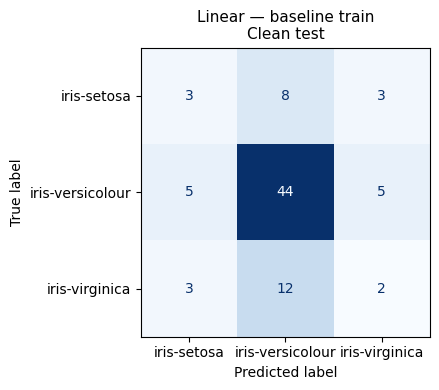


─────────────────────────────────────────────────────────────────
Model: Linear — baseline train | Test: Noisy test
-----------------------------------------------------------------
Accuracy: 57.65%
Precision (Macro): 38.67%
Recall (Macro): 38.22%
F1 Macro: 37.80%
F1 Weighted: 54.29%
AUC ROC (OVR): 0.6431
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.27      0.21      0.24        14
iris-versicolour       0.69      0.81      0.75        54
  iris-virginica       0.20      0.12      0.15        17

        accuracy                           0.58        85
       macro avg       0.39      0.38      0.38        85
    weighted avg       0.52      0.58      0.54        85



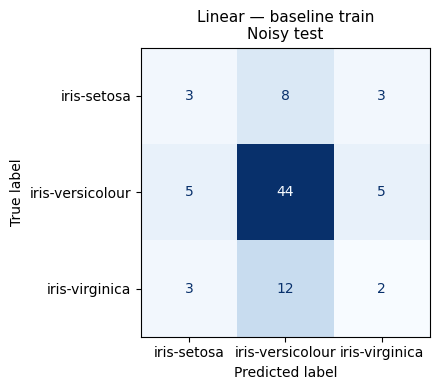


─────────────────────────────────────────────────────────────────
Model: Linear — 10% noisy train | Test: Clean test
-----------------------------------------------------------------
Accuracy: 57.65%
Precision (Macro): 41.84%
Recall (Macro): 39.57%
F1 Macro: 39.89%
F1 Weighted: 54.74%
AUC ROC (OVR): 0.6136
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.33      0.21      0.26        14
iris-versicolour       0.67      0.80      0.73        54
  iris-virginica       0.25      0.18      0.21        17

        accuracy                           0.58        85
       macro avg       0.42      0.40      0.40        85
    weighted avg       0.53      0.58      0.55        85



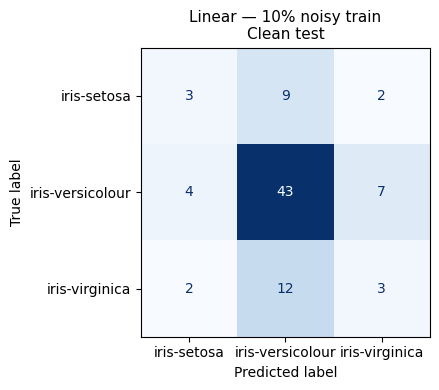


─────────────────────────────────────────────────────────────────
Model: Linear — 10% noisy train | Test: Noisy test
-----------------------------------------------------------------
Accuracy: 57.65%
Precision (Macro): 41.84%
Recall (Macro): 39.57%
F1 Macro: 39.89%
F1 Weighted: 54.74%
AUC ROC (OVR): 0.5999
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.33      0.21      0.26        14
iris-versicolour       0.67      0.80      0.73        54
  iris-virginica       0.25      0.18      0.21        17

        accuracy                           0.58        85
       macro avg       0.42      0.40      0.40        85
    weighted avg       0.53      0.58      0.55        85



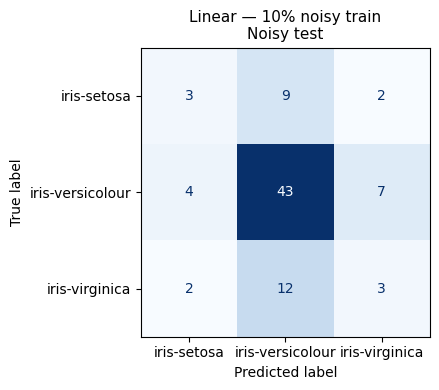


─────────────────────────────────────────────────────────────────
Model: Linear — 30% noisy train | Test: Clean test
-----------------------------------------------------------------
Accuracy: 61.18%
Precision (Macro): 44.60%
Recall (Macro): 40.08%
F1 Macro: 39.76%
F1 Weighted: 55.93%
AUC ROC (OVR): 0.6220
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.33      0.21      0.26        14
iris-versicolour       0.67      0.87      0.76        54
  iris-virginica       0.33      0.12      0.17        17

        accuracy                           0.61        85
       macro avg       0.45      0.40      0.40        85
    weighted avg       0.55      0.61      0.56        85



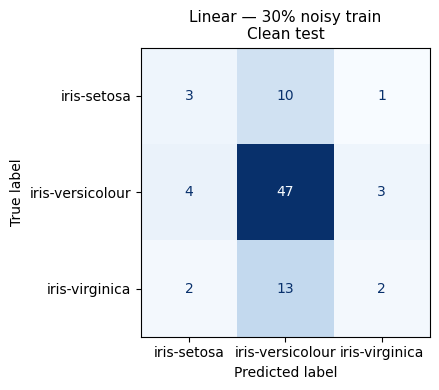


─────────────────────────────────────────────────────────────────
Model: Linear — 30% noisy train | Test: Noisy test
-----------------------------------------------------------------
Accuracy: 61.18%
Precision (Macro): 43.34%
Recall (Macro): 40.08%
F1 Macro: 39.73%
F1 Weighted: 56.18%
AUC ROC (OVR): 0.6242
-----------------------------------------------------------------
                  precision    recall  f1-score   support

     iris-setosa       0.33      0.21      0.26        14
iris-versicolour       0.68      0.87      0.76        54
  iris-virginica       0.29      0.12      0.17        17

        accuracy                           0.61        85
       macro avg       0.43      0.40      0.40        85
    weighted avg       0.54      0.61      0.56        85



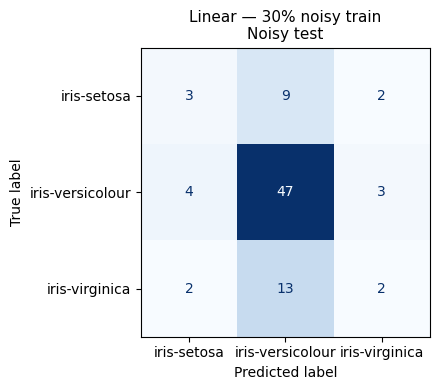

In [14]:
results = {} 

experiments = [
    # (model,      test features,  y_true,          model_label,                test_label)
    (knn_base,    F_test_base_sc,  y_test,       "KNN — baseline train",     "Clean test"),
    (knn_base,    F_test_noisy_sc, y_test_noisy, "KNN — baseline train",     "Noisy test"),
    (knn_noisy10, F_test_base_sc,  y_test,       "KNN — 10% noisy train",    "Clean test"),
    (knn_noisy10, F_test_noisy_sc, y_test_noisy, "KNN — 10% noisy train",    "Noisy test"),
    (knn_noisy30, F_test_base_sc,  y_test,       "KNN — 30% noisy train",    "Clean test"),
    (knn_noisy30, F_test_noisy_sc, y_test_noisy, "KNN — 30% noisy train",    "Noisy test"),
    (lin_base,    F_test_base_sc,  y_test,       "Linear — baseline train",  "Clean test"),
    (lin_base,    F_test_noisy_sc, y_test_noisy, "Linear — baseline train",  "Noisy test"),
    (lin_noisy10, F_test_base_sc,  y_test,       "Linear — 10% noisy train", "Clean test"),
    (lin_noisy10, F_test_noisy_sc, y_test_noisy, "Linear — 10% noisy train", "Noisy test"),
    (lin_noisy30, F_test_base_sc,  y_test,       "Linear — 30% noisy train", "Clean test"),
    (lin_noisy30, F_test_noisy_sc, y_test_noisy, "Linear — 30% noisy train", "Noisy test"),
]

for model, X_te, y_te, m_name, t_name in experiments:
    y_pred, acc, prec, rec, f1_mac, f1_wt, auc = evaluate(model, X_te, y_te, m_name, t_name)
    
    results[(m_name, t_name)] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Macro": f1_mac,
        "F1_Weighted": f1_wt,
        "AUC_ROC": auc
    }
    
    plot_confusion(y_te, y_pred, f"{m_name}\n{t_name}")

In [15]:
!jupyter nbconvert --to pdf __notebook_source__.ipynb --output /kaggle/working/output.pdf

/usr/local/lib/python3.12/dist-packages/mistune.py:435: SyntaxWarning: invalid escape sequence '\|'
  cells[i][c] = re.sub('\\\\\|', '|', cell)
/usr/local/lib/python3.12/dist-packages/nbconvert/filters/filter_links.py:36: SyntaxWarning: invalid escape sequence '\_'
  text = re.sub(r'_', '\_', text) # Escape underscores in display text
[NbConvertApp] WARNING | pattern '__notebook_source__.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-confi